In [1]:
from PIL import Image
import requests
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_con

In [2]:
classes = [
    "kitchen",
    "cooking",
    "food",
    "drink",
    "spill",
    "table",
    "television",
    "phone",
    "laptop",
    "video game",
    "board game",
    "clothes",
    "laundry",
]

In [77]:
valid_dataset = load_dataset("danjacobellis/aria_ea_rgb_100k",split="validation")

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]


KeyboardInterrupt



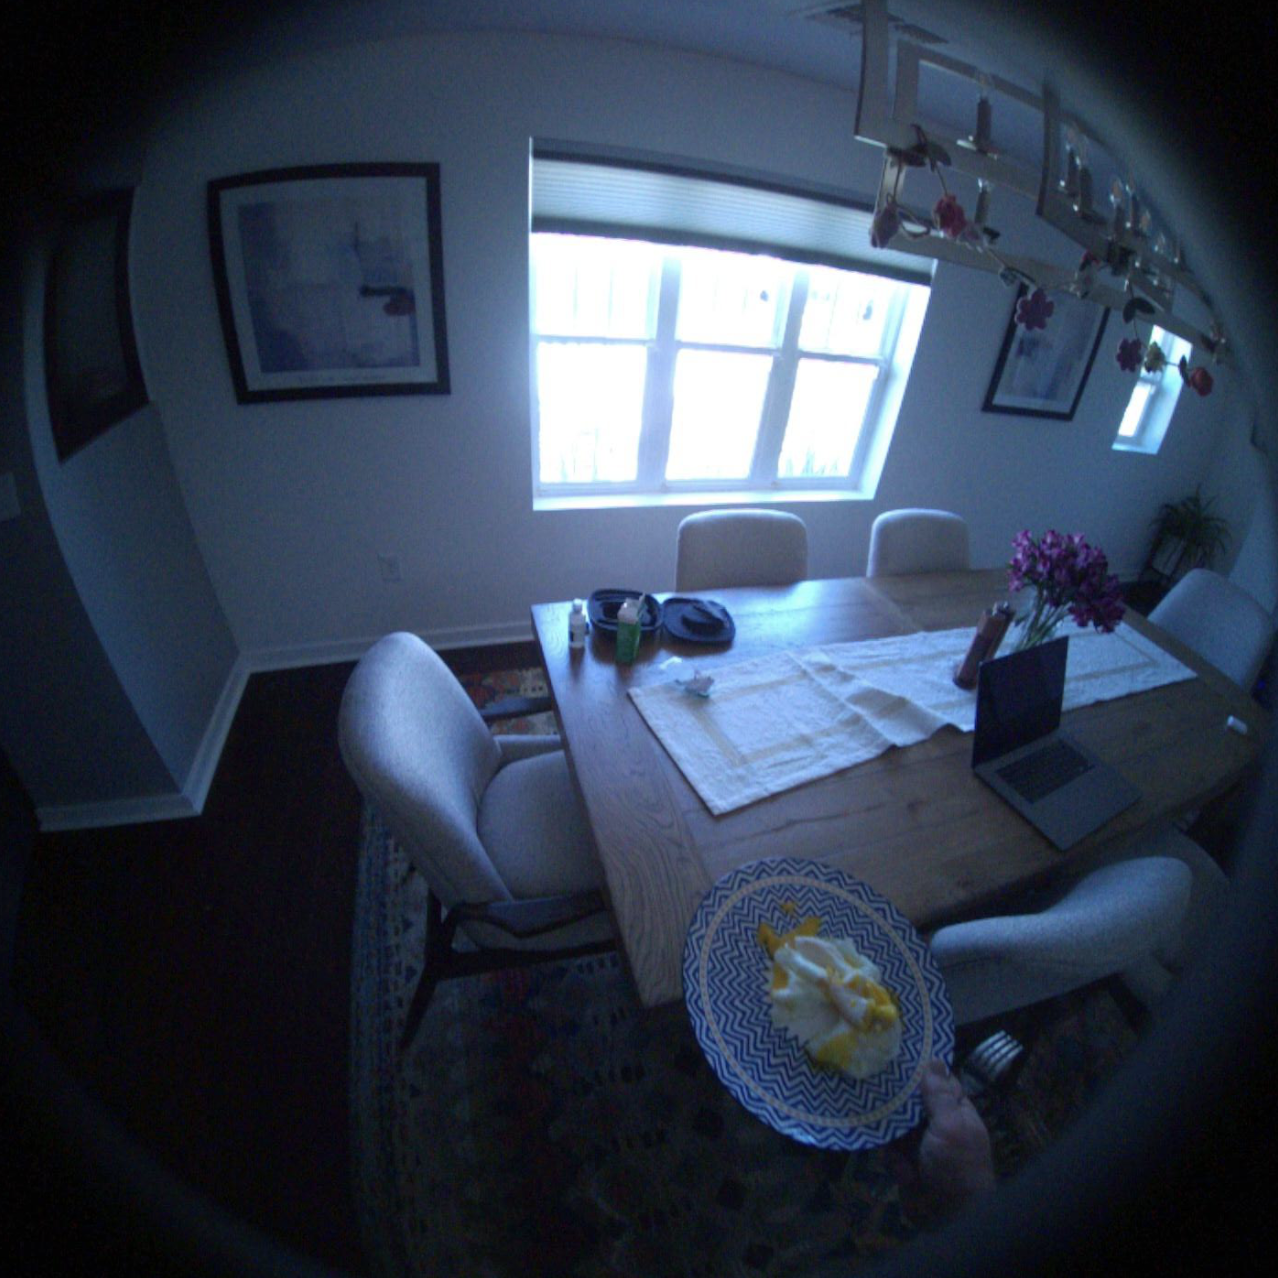

In [3]:
image = Image.open("eggs.png").convert("RGB")
image

In [4]:
inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)
for k in inputs.keys():
    if hasattr(inputs[k], "device"):
        inputs[k] = inputs[k].cuda()

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
classes[probs.argmax()]

'table'

In [5]:
_, ind = np.where(logits_per_image.cpu()>18)
[classes[i] for i in ind]

['food', 'table']